# Quantile / VaR MDP and Regression

### Import Library

In [1]:
using Plots
using JuMP
import HiGHS
using DataFrames
using BenchmarkTools
using Optim
using CSV
using Statistics
using Combinatorics
using SparseArrays

# Document Organization

# 0. Define problem and known functions

### VaR functions
Please read document 1ComputeFastCVaR for the description of basic function and algorithms.

In [2]:
# O(Nlog(N)) with sort
function distribution(X,p)
    d = DataFrame(X = X, p = p)
    d = d[d.p .> 0,:]
    d = combine(groupby(d, ["X"]),df -> DataFrame(p = sum(df.p)) ) 
    sort!(d,["X"]) 
    return d
end


# O(N) code for cumulative adding values
function cumulativeSum(V)
    N = length(V)
    Vsum = zeros(N)
    Vsum[1] = V[1]
    for i in 2:N
        Vsum[i] = Vsum[i-1] + V[i]
    end
    return Vsum
end

function delta(V)
   return [ V[1] ; V[ Not(1)] - V[Not(length(V))] ] 
end
            

# Fast CVaR function takes in a distribution (d) and a vector of risk (Alpha)
function CVaR(d,Alpha)
    # Set lambda 
    Lambda = 1 .- Alpha
    
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    j = 1
    
    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    d.XTP = cumulativeSum(d.X .* d.p)
    
    # Special Case 1: if risk is 0 just use minimum
    while (j <= M) && (Lambda[j] == 0)
        output[j] = minimum(d[d.p .> 0,:].X)
        j+=1
    end  
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = (d.X[1]*(Lambda[j]))/Lambda[j]
        j+=1
    end
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = (d.XTP[i-1] + d.X[i]*(Lambda[j] - d.Psum[i-1]))/Lambda[j]
            j+=1
        end
    end  
    
    while (j <= M)
        output[j] = d.XTP[N]
        j+=1
    end
    
    return output
end             
               
function CVaR2Distribution( cvar , αs ; sig = 10)
    λ = 1 .- αs
    p = delta( λ )
    X = round.( delta( λ .* cvar ) ./ (p) ;sigdigits = sig)
    d = distribution(X,p)
    return d
end

function cond_dist(X,p_cond,pr,S)
    d = DataFrame(X = X, p_cond = p_cond)
    d = d[d.p_cond .> 0,:]
    d.Psum_cond = cumulativeSum(d.p_cond)
    d.p = d.p_cond .* pr
    d.S .= S
    return d
end

function Trisk(conditional_risks , searchVector; add=0, S = 1)
    temp_conditional_risk = copy(conditional_risks)
    temp_conditional_risk[S] += add
    return [searchsortedfirst(searchVector, r) for r ∈ temp_conditional_risk]
end

# CVaR_VI function takes in MDP, a distribution (d) and a vector of risk (Alpha)
function CVaR_VI(ds,Alpha,lSl,Psa)
    
    # compute joint distribution
    d = reduce(vcat,ds)
    d = d[d.p .> 0,:]
    sort!( d , ["X"] )
    
    # Set lambda 
    Lambda = 1 .- Alpha
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    risk_P = ones(Int,(lSl,M))
    risk_s = [0.0 for s ∈ 1:lSl]

    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    d.XTP = cumulativeSum(d.X .* d.p)
    
    j = 1
    # Special Case 1: if risk is 0 just use minimum
    while (j <= M) && (Lambda[j] == 0)
        output[j] = minimum(d.X)
        risk_P[:,j] = Trisk( risk_s , Lambda)
        j+=1
    end
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = d.X[1]
        risk_P[:,j] = Trisk(risk_s,Lambda, add = (Lambda[j]/Psa[d.S[1]]) , S = d.S[1])
        j+=1
    end
    risk_s[d.S[1]] = d.Psum_cond[1]
    
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = (d.XTP[i-1] + d.X[i]*(Lambda[j] - d.Psum[i-1]))/Lambda[j]
            risk_P[:,j] = Trisk(risk_s,Lambda, add = (Lambda[j] - d.Psum[i-1])/Psa[d.S[i]] , S = d.S[i])
            j+=1 
        end
        risk_s[d.S[i]] = d.Psum_cond[i]
    end  
    
    while (j <= M)
        output[j] = d.XTP[N]
        risk_P[:,j] = Trisk(risk_s , Lambda)
        j+=1
    end
    
    return (output = output,riskTrans = risk_P)
end
    
function CVaR_MDP2(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    TransRisk = [ones(Int,(MDP.lSl,MDP.lSl,M)) for t in 1:T]
    for t in T:-1:1
        TransRiskTemp = ones(Int,(MDP.lSl,MDP.lSl,M,MDP.lAl))
        for s in MDP.S
            for a in MDP.A
                Vs = [ cond_dist( MDP.R[s,a,s2] .+ MDP.γ .* V[t+1][s2].X  ,
                        V[t+1][s2].p , MDP.P[s,a,s2], s2) for s2 in 1:MDP.lSl]
                VIout = CVaR_VI(Vs,  Alpha, MDP.lSl, MDP.P[s,a,:] )
                TransRiskTemp[s,:,:,a] = VIout.riskTrans
                Q[t][s,:,a] = VIout.output
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            for m in 1:M
                TransRisk[t][s,:,m] = TransRiskTemp[s,:,m,π[t][s,m]]
            end
        end
        for s in MDP.S
            V[t][s] = CVaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (π=π,V̂=V̂,TransRisk=TransRisk,Alpha = Alpha)
end
            
                                                                
function RtγV(R,γ,V,P) # distribution(X,p)
    return distribution(
        reduce(vcat,[rew .+ γ .* V[s].X for (s,rew) in enumerate(R)]),
        reduce(vcat,[prob .* V[s].p for (s,prob) in enumerate(P)]) )
end

function CVaR_MDP(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    for t in T:-1:1
        for s in MDP.S
            for a in MDP.A
                Q[t][s,:,a] = CVaR(RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:]),Alpha)
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            V[t][s] = CVaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (Q=Q,π=π,V=V,V̂=V̂)
end
                                                                                                
# Convert a data frame to MDP.
function df2MDP(df;γ = 0.90)
    S = unique([df.idstatefrom;df.idstateto])
    A = unique(df.idaction)
    lSl = length(S)
    lAl = length(A)
    P = zeros((lSl,lAl,lSl))
    R = zeros((lSl,lAl,lSl))
    for i in eachrow(df)
        P[i.idstatefrom,i.idaction,i.idstateto] += i.probability
        R[i.idstatefrom,i.idaction,i.idstateto] += i.reward
    end
    return (S=S,A=A,P=P,R=R,lSl=lSl,lAl=lAl,γ=γ)
end

function df2MMDP(df;γ = 0.90)
    S = unique([df.idstatefrom;df.idstateto])
    A = unique(df.idaction)
    M = unique(df.idoutcome)
    lSl = length(S)
    lAl = length(A)
    lMl = length(M)
    P = zeros((lMl,lSl,lAl,lSl))
    R = zeros((lMl,lSl,lAl,lSl))
    for m in M
        dftemp = filter(x -> x.idoutcome == m ,df)
        tempmdp = df2MDP(dftemp;γ = γ)
        P[m,:,:,:] = tempmdp.P
        R[m,:,:,:] = tempmdp.R
    end
    return (S=S,A=A,P=P,R=R,lSl=lSl,lAl=lAl,γ=γ)
end

function MMDP2MDP(MMDP)
    return(S=MMDP.S,A=MMDP.A,P=mean(MMDP.P,dims=1)[1,:,:,:],R=mean(MMDP.R,dims=1)[1,:,:,:],lSl=MMDP.lSl,lAl=MMDP.lAl,γ=MMDP.γ)
end

MMDP2MDP (generic function with 1 method)

In [3]:
function VaR2Distribution( var , αs ; sig = 10)
    λ = 1 .- αs
    p = delta( λ )
    d = distribution(var,p)
    return d
end

# Fast VaR function takes in a distribution (d) and a vector of risk (Alpha)
function VaR(d,Alpha)
    # Set lambda 
    Lambda = 1 .- Alpha
    
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    j = 1
    
    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumsum(d.p)    
    for i in 1:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = d.X[i]
            j+=1
        end
    end  
    output[j:M] .= d.X[N]
    
    return output
end       

# VaR_VI function takes in MDP, a distribution (d) and a vector of risk (Alpha)
function VaR_VI(ds,Alpha,lSl,Psa)
    
    # compute joint distribution
    d = reduce(vcat,ds)
    d = d[d.p .> 0,:]
    sort!( d , ["X"] )
    
    # Set lambda 
    Lambda = 1 .- Alpha
    M = length(Alpha)
    N = nrow(d)
    output = zeros(M)
    risk_P = ones(Int,(lSl,M))
    risk_s = [0.0 for s ∈ 1:lSl]

    # Here we precompute repeatedly used values, Psum and XTP.
    d.Psum = cumulativeSum(d.p)
    
    j = 1
    
    # General Case for i==1, d[i-1,:] is not valid
    while (j <= M) && (Lambda[j] <= d.Psum[1])
        output[j] = d.X[1]
        risk_P[:,j] = Trisk( risk_s , Lambda, add = (Lambda[j]/Psa[d.S[1]]) , S = d.S[1] )
        j+=1
    end
    risk_s[d.S[1]] = d.Psum_cond[1]
    
    # General Cases
    for i in 2:N
        while (j <= M) && (Lambda[j] <= d.Psum[i])
            output[j] = d.X[i]
            risk_P[:,j] = Trisk(risk_s,Lambda, add = (Lambda[j] - d.Psum[i-1])/Psa[d.S[i]] , S = d.S[i])
            j+=1 
        end
        risk_s[d.S[i]] = d.Psum_cond[i]
    end  
    
    while (j <= M)
        output[j] = d.X[N]
        risk_P[:,j] = Trisk(risk_s , Lambda)
        j+=1
    end
    
    return (output = output,riskTrans = risk_P)
end

function VaR_MDP(MDP;T=10,M=10001)
    Alpha = LinRange(1,0,M)
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    V̂ = [zeros(MDP.lSl,M) for t in 1:T]
    π = [zeros(Int64,MDP.lSl,M) for t in 1:T]
    Q = [zeros(MDP.lSl,M,MDP.lAl) for t in 1:T]
    TransRisk = [ones(Int,(MDP.lSl,MDP.lSl,M)) for t in 1:T]
    for t in T:-1:1
        TransRiskTemp = ones(Int,(MDP.lSl,MDP.lSl,M,MDP.lAl))
        for s in MDP.S
            for a in MDP.A
                Vs = [ cond_dist( MDP.R[s,a,s2] .+ MDP.γ .* V[t+1][s2].X  ,
                        V[t+1][s2].p , MDP.P[s,a,s2], s2) for s2 in 1:MDP.lSl]
                VIout = VaR_VI(Vs,  Alpha, MDP.lSl, MDP.P[s,a,:] )
                TransRiskTemp[s,:,:,a] = VIout.riskTrans
                Q[t][s,:,a] = VIout.output
            end
        end
        opt = findmax(Q[t],dims=3)
        V̂[t] = opt[1][:,:,1]
        π[t] = [i[3] for i in opt[2][:,:,1]]
        for s in MDP.S
            for m in 1:M
                TransRisk[t][s,:,m] = TransRiskTemp[s,:,m,π[t][s,m]]
            end
        end
        for s in MDP.S
            V[t][s] = VaR2Distribution(V̂[t][s,:],Alpha)
        end
    end
    return (π=π,V̂=V̂,TransRisk=TransRisk,Alpha = Alpha)
end

VaR_MDP (generic function with 1 method)

In [4]:
# to avoid making a copy of parsed columns, use CSV.read
df = CSV.read("C:/GITHUB/rmdp-jl-2/data/TabMDP/easy2.csv", DataFrame)
df[:,["idstatefrom","idaction","idstateto"]] = df[:,["idstatefrom","idaction","idstateto"]] .+ 1
# Define a fixed discount and MDP
MDP = df2MDP(df;γ = 0.9)
    
M = 1001
T = 2
sol = VaR_MDP(MDP;T=T,M=M)
@elapsed VaR_MDP(MDP;T=T,M=M)

0.0059488

After we read in a simple MDP, we will discretize our quantile into $1001$ uniform levels, and only consider $T=2$.

To demonstrate the empirical plausible error of the algorithm, we will compute the true CVaR for all possible time dependent deterministic policy $\Pi_\forall$. Then we will compute the optimal value function with 
$$\text{VaR}_\alpha[ \mathfrak{R}^{\pi_\star}_{1:T}(s_0)] =  \max_{\pi \in \Pi_\forall} \{~\text{VaR}_\alpha[\mathfrak{R}^\pi_{1:T}(s_0)] ~\} \qquad, \forall \alpha , s_0 \in S .$$

In [8]:
∀loc = [(i,j) for i in 1:T for j in MDP.S]
a2 = reduce(vcat,[collect(combinations(∀loc,i)) for i in 0:length(∀loc)])
function sparsePi(indexes,nRow,nCol)
    I = [i[1] for i in indexes]
    J = [i[2] for i in indexes]
    return(Array{Int8}(sparse(I,J,1,nRow,nCol)) .+ Int8(1)) 
end
Π∀ =[ sparsePi(act2,T,MDP.lSl) for act2 in a2]
nΠ∀ = length(Π∀)

16

Now we have all the combination of possible policies, we could compute their respective value function distribution, and then compute VaR from each of the distribution and take the maximum as optimal policy.

In [9]:
function V_distribution(MDP,policy;T=10) # policy[t,s]
    V = [[DataFrame() for s in MDP.S] for t in 1:(T+1)]
    V[T+1] = [DataFrame(X = [0], p = [1]) for s in MDP.S]
    for t in T:-1:1
        for s in MDP.S
            a = policy[t,s]
            V[t][s] = RtγV(MDP.R[s,a,:],MDP.γ,V[t+1],MDP.P[s,a,:])
        end
    end
    return V
end

Vπ = unique([ V_distribution(MDP,policy;T=T) for policy in Π∀])
Alpha = LinRange(1,0,M)
t = 1
Real_optimal_VaR = [ reduce((x,y) -> max.(x,y), [VaR(v[t][s],Alpha) for v in Vπ]) for s in MDP.S]
s = 2
ErrMax = findmax(abs.(sol.V̂[t][s,:].-Real_optimal_VaR[s]))
error = round(ErrMax[1],digits = 3)

0.0

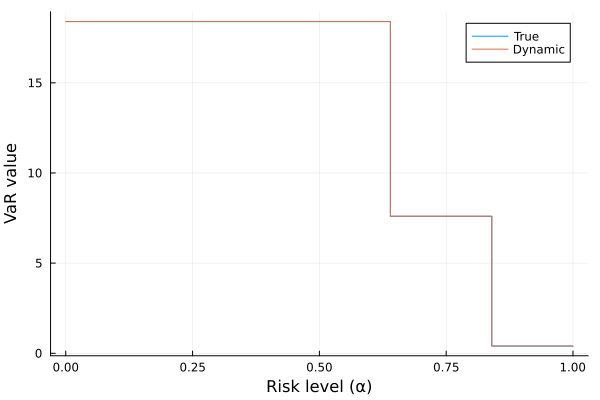

In [12]:
plot(Alpha, [Real_optimal_VaR[s], sol.V̂[t][s,:]],linetype=:steppre,label = ["True" "Dynamic"])
# plot!([Alpha[ErrMax[2]],Alpha[ErrMax[2]]],[sol.V̂[t][s,ErrMax[2]],Real_optimal_VaR[s][ErrMax[2]]], linewidth=3,lc=:black,linetype=:steppre , label = raw"Max ϵ ="*"$error")
xlabel!("Risk level (α)")
ylabel!("VaR value")

At least for T=2 we can see that the VaR was correct at location where CVaR wasn't. Now weextend the test for VaR MDP.